# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations.

## What we'll do in this notebook
1. Define a neural network model
2. Find its maximum likelihood parameters using Global Optimisation
3. Redefine it as a Bayesian neural network allowing biases to be sampled from a prior.
4. Compute the evidence and posterior of the parameters.


## Data

We'll use the N-bit majority problem as our data. This is a binary classification problem where the input is a sequence of bits and the output is 1 if the majority of the bits are 1, and 0 otherwise.

In [1]:
import os

from jax import tree_util

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")
    raise

from itertools import product

import jax
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import resample

tfpd = tfp.distributions


def pytree_unravel(example_tree):
    """
    Returns functions to ravel and unravel a pytree.
    """
    leaf_list, tree_def = tree_util.tree_flatten(example_tree)

    sizes = [leaf.size for leaf in leaf_list]
    shapes = [leaf.shape for leaf in leaf_list]

    def ravel_fun(pytree):
        leaf_list, tree_def = tree_util.tree_flatten(pytree)
        return jnp.concatenate([leaf.ravel() for leaf in leaf_list])

    def unravel_fun(flat_array):
        leaf_list = []
        start = 0
        for size, shape in zip(sizes, shapes):
            leaf_list.append(flat_array[start:start + size].reshape(shape))
            start += size
        return tree_util.tree_unflatten(tree_def, leaf_list)

    return ravel_fun, unravel_fun


INFO[2024-01-10 16:55:05,659]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-01-10 16:55:05,660]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-01-10 16:55:05,661]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-01-10 16:55:05,662]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Generate data

def n_bit_majority(x):
    return jnp.sum(x) > (x.size / 2)


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))  #N,2
y = vmap(n_bit_majority)(x)[:, None]  #N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [ True]
[1. 1. 1. 1. 1. 0. 1.] -> [ True]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [ True]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [ True]
[1. 1. 1. 0. 1. 1. 1.] -> [ True]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [ True]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [ True]
[1. 1. 1. 0. 0. 0. 1.] -> [ True]
[1. 1. 1. 0. 0. 0. 0.] -> [False]
[1. 1. 0. 1. 1. 1. 1.] -> [ True]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [ True]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [ True]
[1. 1. 0. 1. 0. 0. 1.] -> [ True]
[1. 1. 0. 1. 0. 0. 0.] -> [False]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [ True]
[1. 1. 0. 0. 1. 0. 1.] -> [ True]
[1. 1. 0. 0. 1. 0. 0.] -> [False]
[1. 1. 0. 0. 0. 1. 1.] -> [ True]
[1. 1. 0

In [3]:
from jaxns import Prior, Model


def prior_model():
    def compute_logits(x):
        mlp = hk.Sequential([hk.Linear(1),
                             jax.nn.sigmoid,
                             hk.Linear(1)])
        return mlp(x)

    fn = hk.without_apply_rng(hk.transform(compute_logits))
    init_params = fn.init(random.PRNGKey(0), x)

    ravel_fn, unravel_fn = pytree_unravel(init_params)
    ndims = ravel_fn(init_params).size
    flat_params = yield Prior(tfpd.Uniform(-10. * jnp.ones(ndims), 10. * jnp.ones(ndims)), name='flat_params')
    params = unravel_fn(flat_params)
    logits = fn.apply(params, x)
    return logits


def log_likelihood(logits):
    # Classification probelm, so we use a Bernoulli likelihood
    return tfpd.Bernoulli(logits=logits).log_prob(y).mean()


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)




In [4]:

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2024-01-10 16:55:07,850]: Sanity check...
INFO[2024-01-10 16:55:08,319]: Sanity check passed


In [5]:
from jaxns.experimental import DefaultGlobalOptimisation, GlobalOptimisationTerminationCondition

go = DefaultGlobalOptimisation(model=model,
                               num_search_chains=model.U_ndims * 10,
                               num_parallel_workers=len(jax.devices()))

results = go(
    random.PRNGKey(0),
    GlobalOptimisationTerminationCondition(log_likelihood_contour=-0.01,
                                           max_likelihood_evaluations=2e6)
)
go.summary(results)


INFO[2024-01-10 16:55:08,340]: Using 6 parallel workers, each running identical samplers.


--------
Termination Conditions:
--------
likelihood evals: 343262
samples: 14700
likelihood evals / sample: 23.4
--------
max(log_L)=-0.028
relative spread: 0.00063
absolute spread: 1.7e-05
--------
flat_params[#]: max(L) est.
flat_params[0]: -10.0
flat_params[1]: 2.91
flat_params[2]: 2.91
flat_params[3]: 2.91
flat_params[4]: 2.91
flat_params[5]: 2.9
flat_params[6]: 2.91
flat_params[7]: 2.91
flat_params[8]: -5.25
flat_params[9]: 10.0
--------


In [6]:
logits = model.prepare_input(results.U_solution)[0]
predictions = jax.nn.sigmoid(logits)
for i in range(len(y)):
    pred = predictions[i] > 0.5
    print(f"{i}: {x[i]} -> {y[i]} | pred: {pred} {'✓' if pred == y[i] else '✗'}")

accuracy = jnp.mean((predictions > 0.5) == y)
print(f"Accuracy: {accuracy * 100:.1f}%")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [ True] ✓
1: [1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: [ True] ✓
2: [1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: [ True] ✓
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [ True] ✓
4: [1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: [ True] ✓
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [ True] ✓
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [ True] ✓
7: [1. 1. 1. 1. 0. 0. 0.] -> [ True] | pred: [ True] ✓
8: [1. 1. 1. 0. 1. 1. 1.] -> [ True] | pred: [ True] ✓
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [ True] ✓
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [ True] ✓
11: [1. 1. 1. 0. 1. 0. 0.] -> [ True] | pred: [ True] ✓
12: [1. 1. 1. 0. 0. 1. 1.] -> [ True] | pred: [ True] ✓
13: [1. 1. 1. 0. 0. 1. 0.] -> [ True] | pred: [ True] ✓
14: [1. 1. 1. 0. 0. 0. 1.] -> [ True] | pred: [ True] ✓
15: [1. 1. 1. 0. 0. 0. 0.] -> [False] | pred: [False] ✓
16: [1. 1. 0. 1. 1. 1. 1.] -> [ True] | pred: [ True] ✓
17: [1. 1. 0. 1. 1. 1. 0.] -> [ True] | pred: [ True] ✓
18

In [7]:


def prior_model():
    bias_scale = yield Prior(tfpd.Uniform(0.1, 10.), name='bias_scale').parametrised()

    bias = yield Prior(tfpd.Normal(jnp.zeros(1), bias_scale * jnp.ones(1)), name='bias')

    def compute_logits(x):
        mlp = hk.Sequential([hk.Linear(1, with_bias=False),
                             lambda x: x + bias,
                             jax.nn.sigmoid,
                             hk.Linear(1)])
        return mlp(x)

    fn = hk.without_apply_rng(hk.transform(compute_logits))
    init_params = fn.init(random.PRNGKey(0), x)

    ravel_fn, unravel_fn = pytree_unravel(init_params)
    ndims = ravel_fn(init_params).size
    # We'll parameterise the NN's params
    flat_params = yield Prior(
        tfpd.Uniform(-10. * jnp.ones(ndims),
                     10. * jnp.ones(ndims)),
        name='flat_params').parametrised()
    params = unravel_fn(flat_params)
    logits = fn.apply(params, x)
    return logits


def log_likelihood(logits):
    # Classification probelm, so we use a Bernoulli likelihood
    return tfpd.Bernoulli(logits=logits).log_prob(y).mean()


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)


In [8]:
from jaxns.experimental import EvidenceMaximisation

results, opt_params = EvidenceMaximisation(
    model=model,
    ns_kwargs=dict(max_samples=1e5)
).train(num_steps=10)


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]
Step 0: log Z = -0.7434, l_oo = {'~': {'bias_scale_param': Array(0., dtype=float32), 'flat_params_param': Array(8.173739e-11, dtype=float32)}}:   0%|          | 0/100 [00:00<?, ?it/s]
Step 0: log Z = -0.7434, l_oo = {'~': {'bias_scale_param': Array(0., dtype=float32), 'flat_params_param': Array(8.173739e-11, dtype=float32)}}:   0%|          | 0/100 [00:00<?, ?it/s]
Step 0: log Z = -0.7434 +- 0.0362:  10%|█         | 1/10 [00:02<00:18,  2.03s/it]

Terminating at step 0 due to l(inf) small enough.


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]
Step 0: log Z = -0.7095, l_oo = {'~': {'bias_scale_param': Array(8.951856e-10, dtype=float32), 'flat_params_param': Array(0.000218, dtype=float32)}}:   0%|          | 0/100 [00:01<?, ?it/s]
Step 0: log Z = -0.7095, l_oo = {'~': {'bias_scale_param': Array(8.951856e-10, dtype=float32), 'flat_params_param': Array(0.000218, dtype=float32)}}:   0%|          | 0/100 [00:01<?, ?it/s]
Step 0: log Z = -0.7095, l_oo = {'~': {'bias_scale_param': Array(8.951856e-10, dtype=float32), 'flat_params_param': Array(0.000218, dtype=float32)}}:   1%|          | 1/100 [00:01<02:02,  1.24s/it]
Step 1: log Z = -0.7103, l_oo = {'~': {'bias_scale_param': Array(2.5248637e-05, dtype=float32), 'flat_params_param': Array(0.08825424, dtype=float32)}}:   1%|          | 1/100 [00:01<02:02,  1.24s/it]
Step 1: log Z = -0.7103, l_oo = {'~': {'bias_scale_param': Array(2.5248637e-05, dtype=float32), 'flat_params_param': Array(0.08825424, dtype=float32)}}:   1%|    

Convergence achieved at step 7.


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 11628
samples: 360
phantom samples: 0
likelihood evals / sample: 32.3
phantom fraction (%): 0.0%
--------
logZ=-0.456 +- 0.017
H=-0.02
ESS=32
--------
bias: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
bias: -0.0 +- 0.15 | -0.2 / 0.0 / 0.19 | 0.0 | 0.29
--------


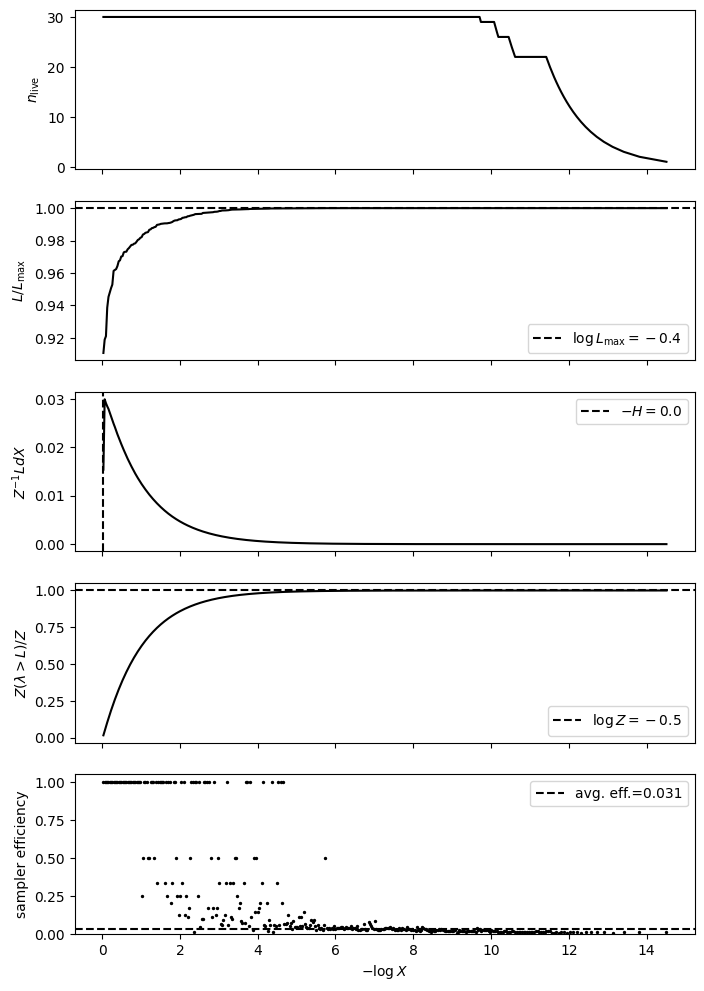

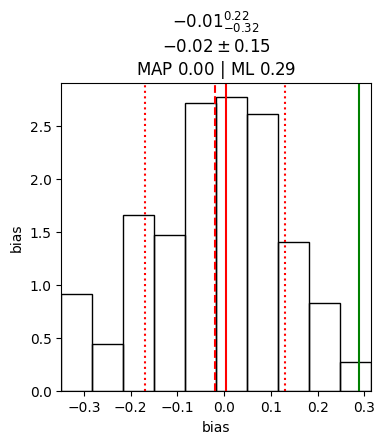

In [9]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

In [10]:
U_samples = resample(random.PRNGKey(45),
                     results.U_samples,
                     results.log_dp_mean,
                     S=int(results.ESS),
                     replace=True)


def predict(U_sample):
    # Apply the opt_params to the model before computing the logits
    logits = model(opt_params).prepare_input(U_sample)[0]
    return jax.nn.sigmoid(logits)


predictions = vmap(predict)(U_samples)
print(predictions)
for i in range(len(y)):
    preds = jnp.percentile(predictions[:, i], jnp.asarray([5, 50, 95]))
    hit = jnp.mean(predictions[:, i]) > 0.5
    print(f"{i}: {x[i]} -> {y[i]} | pred: {preds} {'✓' if hit == y[i] else '✗'}")

accuracy = jnp.mean((jnp.mean(predictions, axis=0) > 0.5) == y)
print(f"Accuracy: {accuracy * 100:.1f}%")

[[[0.81260693]
  [0.7820038 ]
  [0.7820038 ]
  ...
  [0.13765268]
  [0.13765268]
  [0.0493108 ]]

 [[0.81416523]
  [0.7846781 ]
  [0.7846781 ]
  ...
  [0.14661536]
  [0.14661536]
  [0.05315876]]

 [[0.80607915]
  [0.7707676 ]
  [0.7707676 ]
  ...
  [0.10695916]
  [0.10695916]
  [0.0368626 ]]

 ...

 [[0.8094097 ]
  [0.77650696]
  [0.77650696]
  ...
  [0.1213586 ]
  [0.1213586 ]
  [0.04256485]]

 [[0.8029672 ]
  [0.76539457]
  [0.76539457]
  ...
  [0.09548252]
  [0.09548252]
  [0.03248575]]

 [[0.8043955 ]
  [0.7678619 ]
  [0.7678619 ]
  ...
  [0.10053474]
  [0.10053474]
  [0.03439451]]]
0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.8030733 0.8095837 0.8212578] ✓
1: [1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: [0.76557785 0.7768066  0.7967997 ] ✓
2: [1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: [0.76557785 0.7768066  0.7967997 ] ✓
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [0.7004969  0.7199961  0.75471765] ✓
4: [1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: [0.76557785 0.7768066  0.7967997 ] ✓